# Visitor Attendance Forecasting and Analysis

**Objective**: Analyze historical visitor trends and train a Machine Learning model to forecast future daily attendance. This aids in resource allocation (staffing, food supplies) and crowd management.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Configuration
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading and Cleaning
Loading the visitor logs dataset.

In [2]:
df = pd.read_csv('../visitor_data.csv')
df['visit_date'] = pd.to_datetime(df['visit_date'])
print(f"Total Records: {len(df)}")
print("Date Range:", df['visit_date'].min(), "to", df['visit_date'].max())
df.head()

Total Records: 15000
Date Range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00


,visit_date,visitor_name,age,country,event_selected,tickets_count,total_spend_usd
0,2023-07-17,Visitor_40060,53,Sri Lanka,General Entry,2,2
1,2024-05-19,Visitor_87702,20,Sri Lanka,Bottle Feeding (Morning),2,2
2,2023-03-11,Visitor_69730,40,Sri Lanka,General Entry,1,1
3,2023-03-10,Visitor_10046,61,Germany,Bottle Feeding (Afternoon),3,45
4,2023-03-03,Visitor_19066,53,China,General Entry,3,45


## 2. Exploratory Data Analysis (EDA)

### 2.1 Daily Attendance Trends
Aggregating data by date to observe daily footfall.

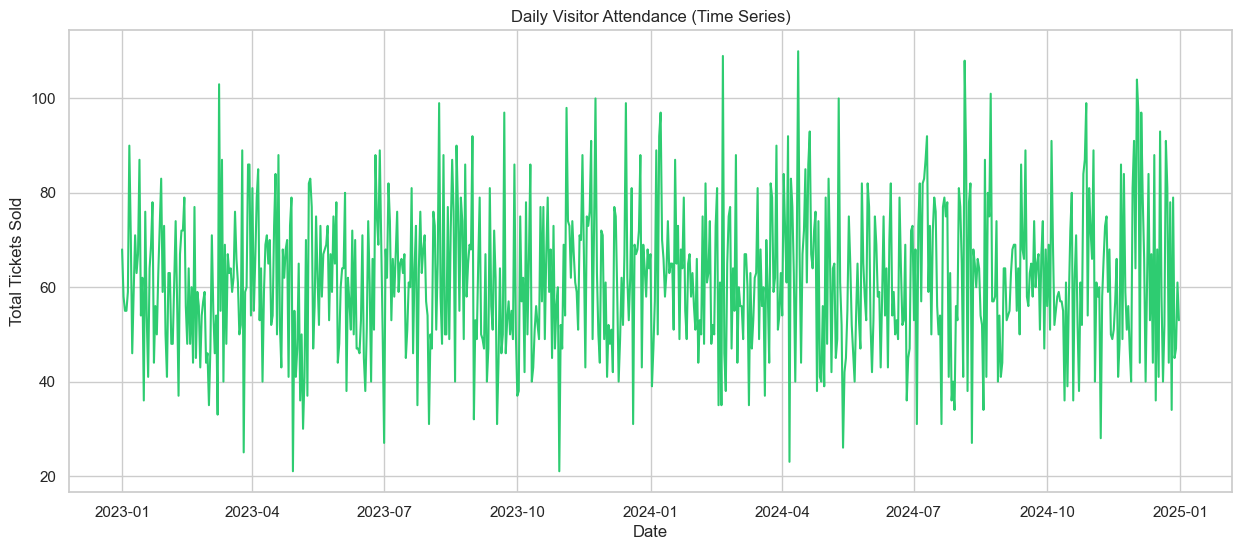

In [3]:
daily_counts = df.groupby('visit_date')['tickets_count'].sum().reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(data=daily_counts, x='visit_date', y='tickets_count', color='#2ecc71')
plt.title('Daily Visitor Attendance (Time Series)')
plt.xlabel('Date')
plt.ylabel('Total Tickets Sold')
plt.show()

### 2.2 Seasonality Analysis
Analyzing visitor traffic by Month and Day of the Week.

/var/folders/jn/xf4lp_l92pgdxbgfnbyl9l8w0000gn/T/ipykernel_38740/205640318.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='tickets_count', data=daily_counts, ax=axes[0], order=obs_months, errorbar=None, palette='viridis')
/var/folders/jn/xf4lp_l92pgdxbgfnbyl9l8w0000gn/T/ipykernel_38740/205640318.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='tickets_count', data=daily_counts, ax=axes[1], order=obs_days, errorbar=None, palette='magma')


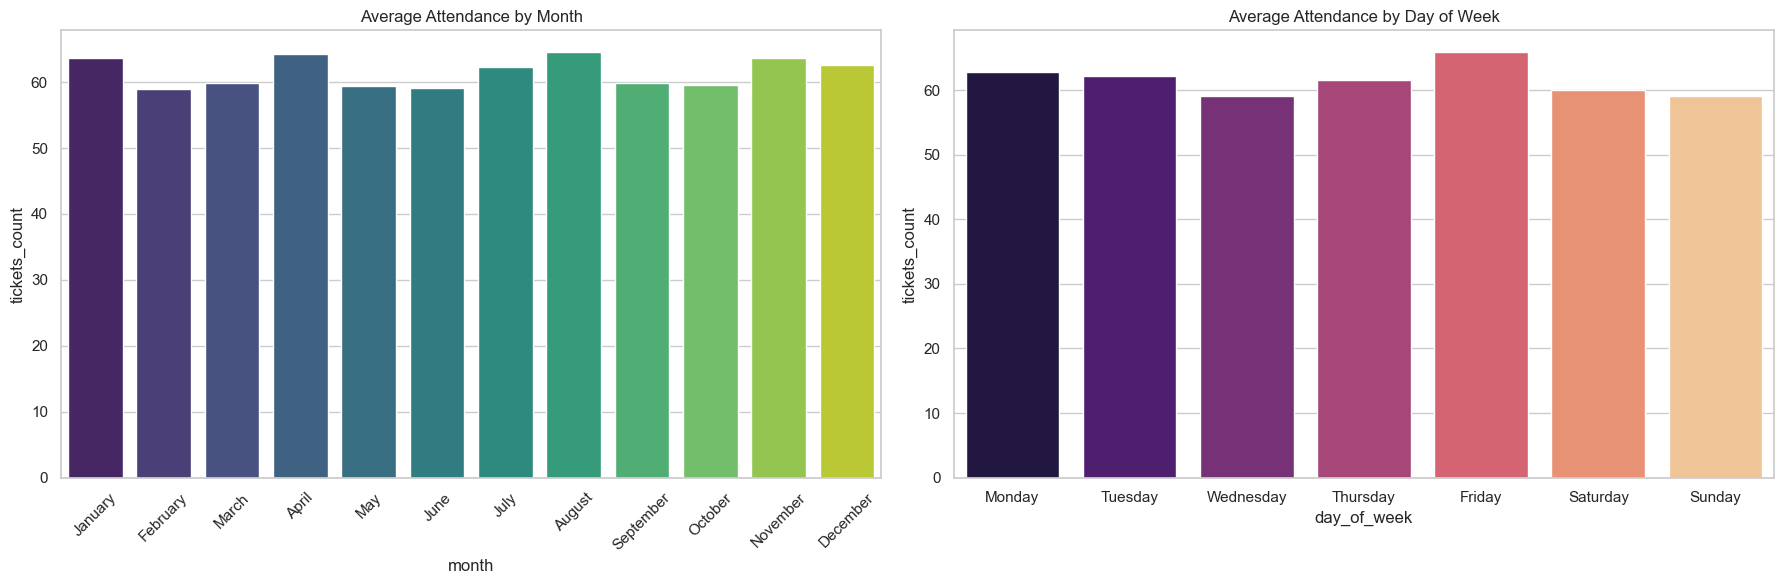

In [4]:
daily_counts['month'] = daily_counts['visit_date'].dt.month_name()
daily_counts['day_of_week'] = daily_counts['visit_date'].dt.day_name()

# Order for plotting
obs_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
obs_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Monthly Trend
sns.barplot(x='month', y='tickets_count', data=daily_counts, ax=axes[0], order=obs_months, errorbar=None, palette='viridis')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title('Average Attendance by Month')

# Weekly Trend
sns.barplot(x='day_of_week', y='tickets_count', data=daily_counts, ax=axes[1], order=obs_days, errorbar=None, palette='magma')
axes[1].set_title('Average Attendance by Day of Week')

plt.tight_layout()
plt.show()

## 3. Feature Engineering
Extracting numerical features for the Regression Model:
* Day of Year (1-365)
* Month (1-12)
* Day of Week (0=Mon, 6=Sun)

In [5]:
model_data = daily_counts[['visit_date', 'tickets_count']].copy()
model_data['day_of_year'] = model_data['visit_date'].dt.dayofyear
model_data['month'] = model_data['visit_date'].dt.month
model_data['day_of_week'] = model_data['visit_date'].dt.dayofweek
model_data.head()

,visit_date,tickets_count,day_of_year,month,day_of_week
0,2023-01-01,68,1,1,6
1,2023-01-02,58,2,1,0
2,2023-01-03,55,3,1,1
3,2023-01-04,55,4,1,2
4,2023-01-05,59,5,1,3


## 4. Model Training (Random Forest Regressor)
We split the data into training (80%) and testing (20%) sets.

In [6]:
X = model_data[['day_of_year', 'month', 'day_of_week']]
y = model_data['tickets_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
print("Model Training Complete.")

Model Training Complete.


## 5. Model Evaluation
Evaluating performance using Mean Absolute Error (MAE) and visualizing predictions vs actuals.

Mean Absolute Error (MAE): 15.70
Root Mean Squared Error (RMSE): 19.86


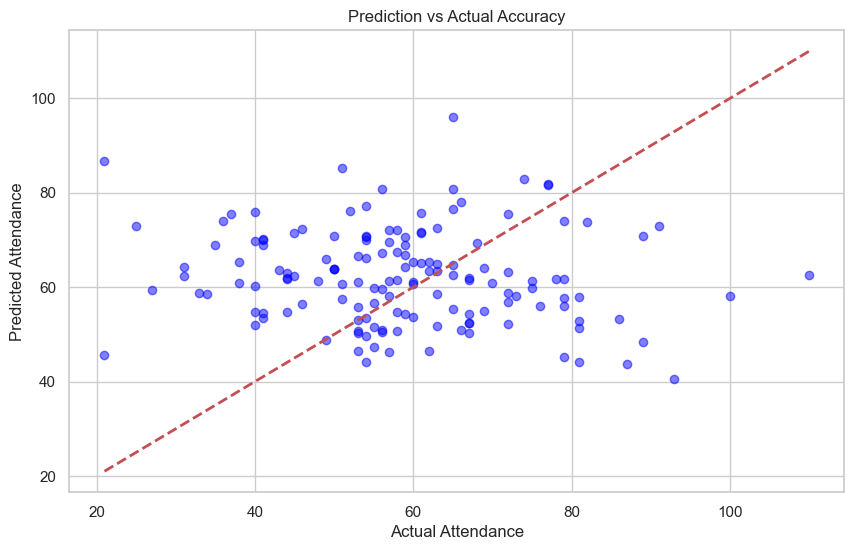

In [7]:
preds = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Visualizing Prediction Accuracy
plt.figure(figsize=(10,6))
plt.scatter(y_test, preds, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Attendance')
plt.ylabel('Predicted Attendance')
plt.title('Prediction vs Actual Accuracy')
plt.show()

## 6. Saving the Model
Saving the trained model for backend integration.

In [8]:
import os
os.makedirs('../models', exist_ok=True)
joblib.dump(rf_model, '../models/forecasting_model.pkl')
print("Forecast Model saved successfully to models/forecasting_model.pkl")

Forecast Model saved successfully to models/forecasting_model.pkl
